# 0.0. Imports e Dados

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
sns.set()
sns.set({'figure.figsize': ( 20, 12 )})

from matplotlib                  import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics             import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## 0.1. Funções

In [2]:
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame(
        {
            'Model_Name': model_name,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        },
        index=[0])

## 0.2. Carregamento dos dados

In [3]:
df = pd.read_excel("Dados.xlsx")

# 1.0. Descrição dos Dados

Por se tratar de uma Base de Dados bem simples, vou pular algumas etapas que costumo fazer aqui, pois apenas analisando, fica claro que não será preciso

## 1.1. Tipos de Dados

In [4]:
df.dtypes
# os dados já vieram na formatação correta

Data      datetime64[ns]
Vendas             int64
dtype: object

## 1.2. Checando Nulos

In [5]:
df.isna().sum()

Data      0
Vendas    0
dtype: int64

## 1.3. Estatística Descritiva

In [6]:
num_attributes = df.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.3.1 Atributos Numéricos

In [7]:
num_attributes = df.select_dtypes( include=['int64', 'float64'] )

# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T     # range
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Vendas,18.0,1692.0,1674.0,755.434783,810.5,426.054276,-0.062009,-0.788224


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Vendas,46.0,755.434783,430.762201,18.0,346.5,810.5,1053.75,1692.0


### 1.3.2 Atributos Categóricos

In [9]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

Series([], dtype: float64)

In [10]:
df1 = df.copy()
df1['Objeto'] = df1['Data'].astype(str)

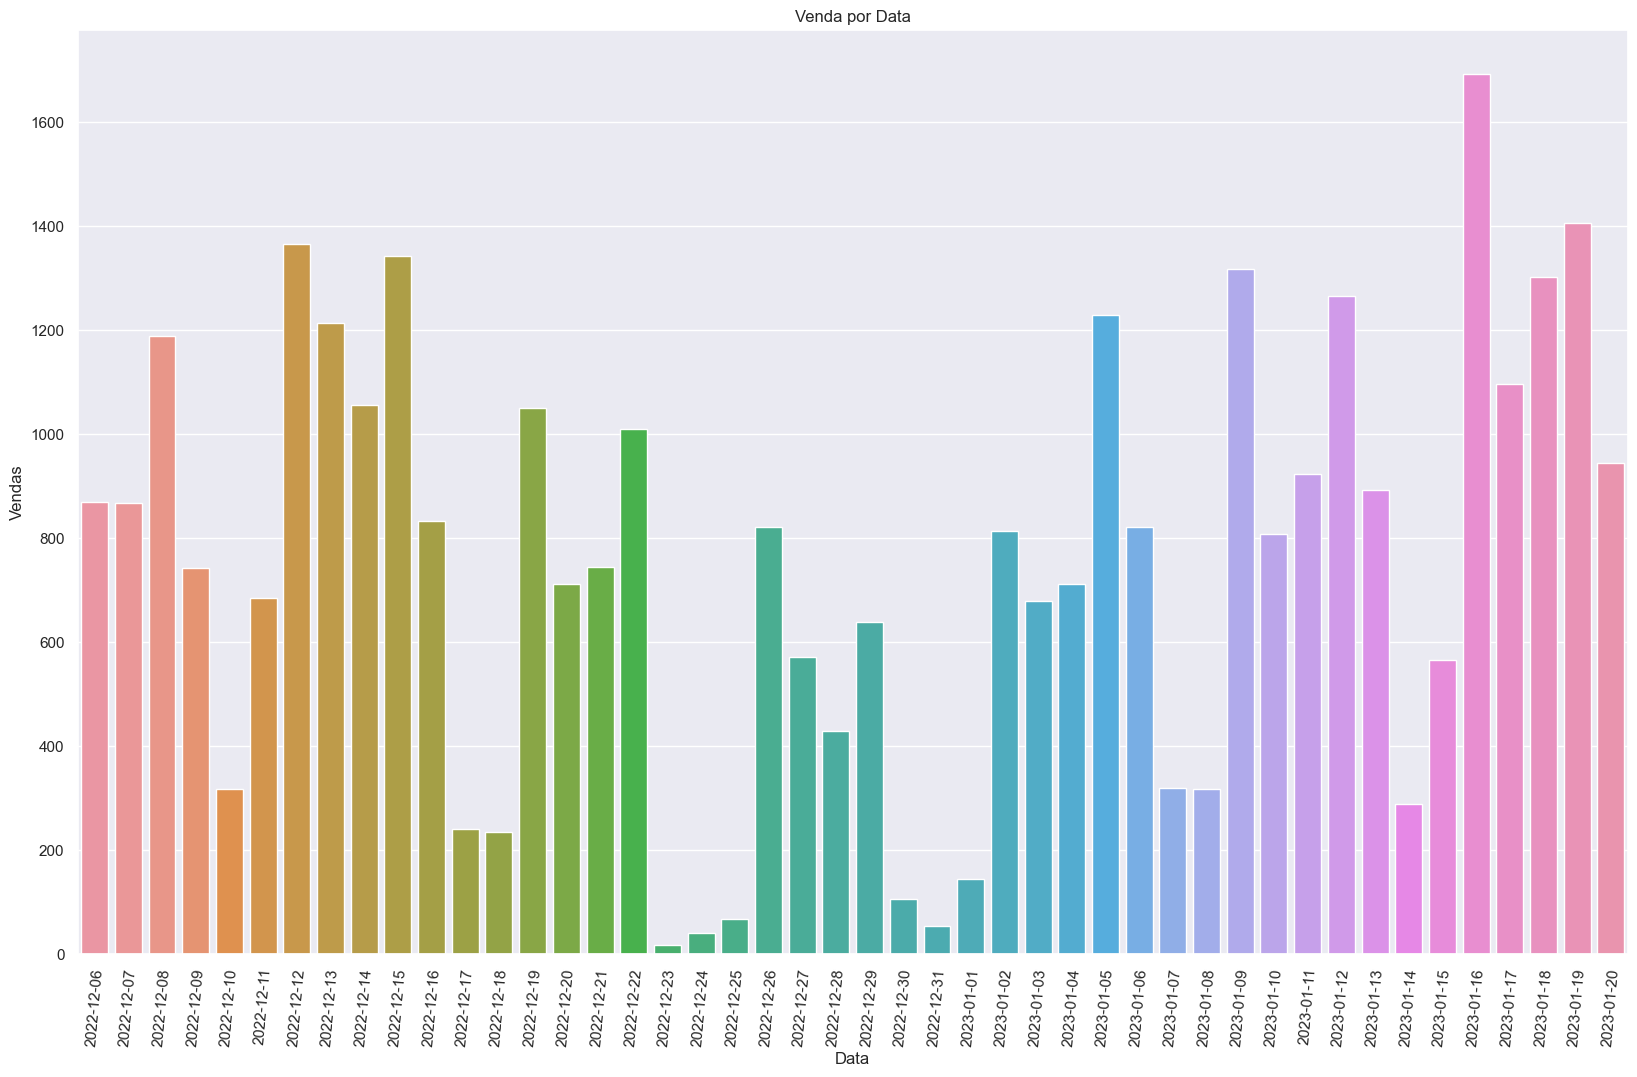

In [11]:
ax = sns.barplot( x='Objeto', y='Vendas', data=df1)
ax.set(title='Venda por Data', xlabel='Data')
plt.xticks(rotation=85);

# 2.0. Treinamento de Algoritmos de Machine Learning

## Performace Treino

Por serem pouquíssimos dados, apenas 45 linhas e duas colunas, o algoritmo não possui features o suficiente para performar com uma boa acuracia, seria preciso mais algumas informações para uma performace melhor 

In [12]:
# separando dados para treino, tirando os 5 ultimos dias
df_train = df.copy()
df_train = df_train.loc[:40, :]

# separando dados para treino, apenas com os 5 ultimos dias
df_test = df.copy()
df_test = df_test.loc[41:, :]
Y_test = df_test['Vendas']

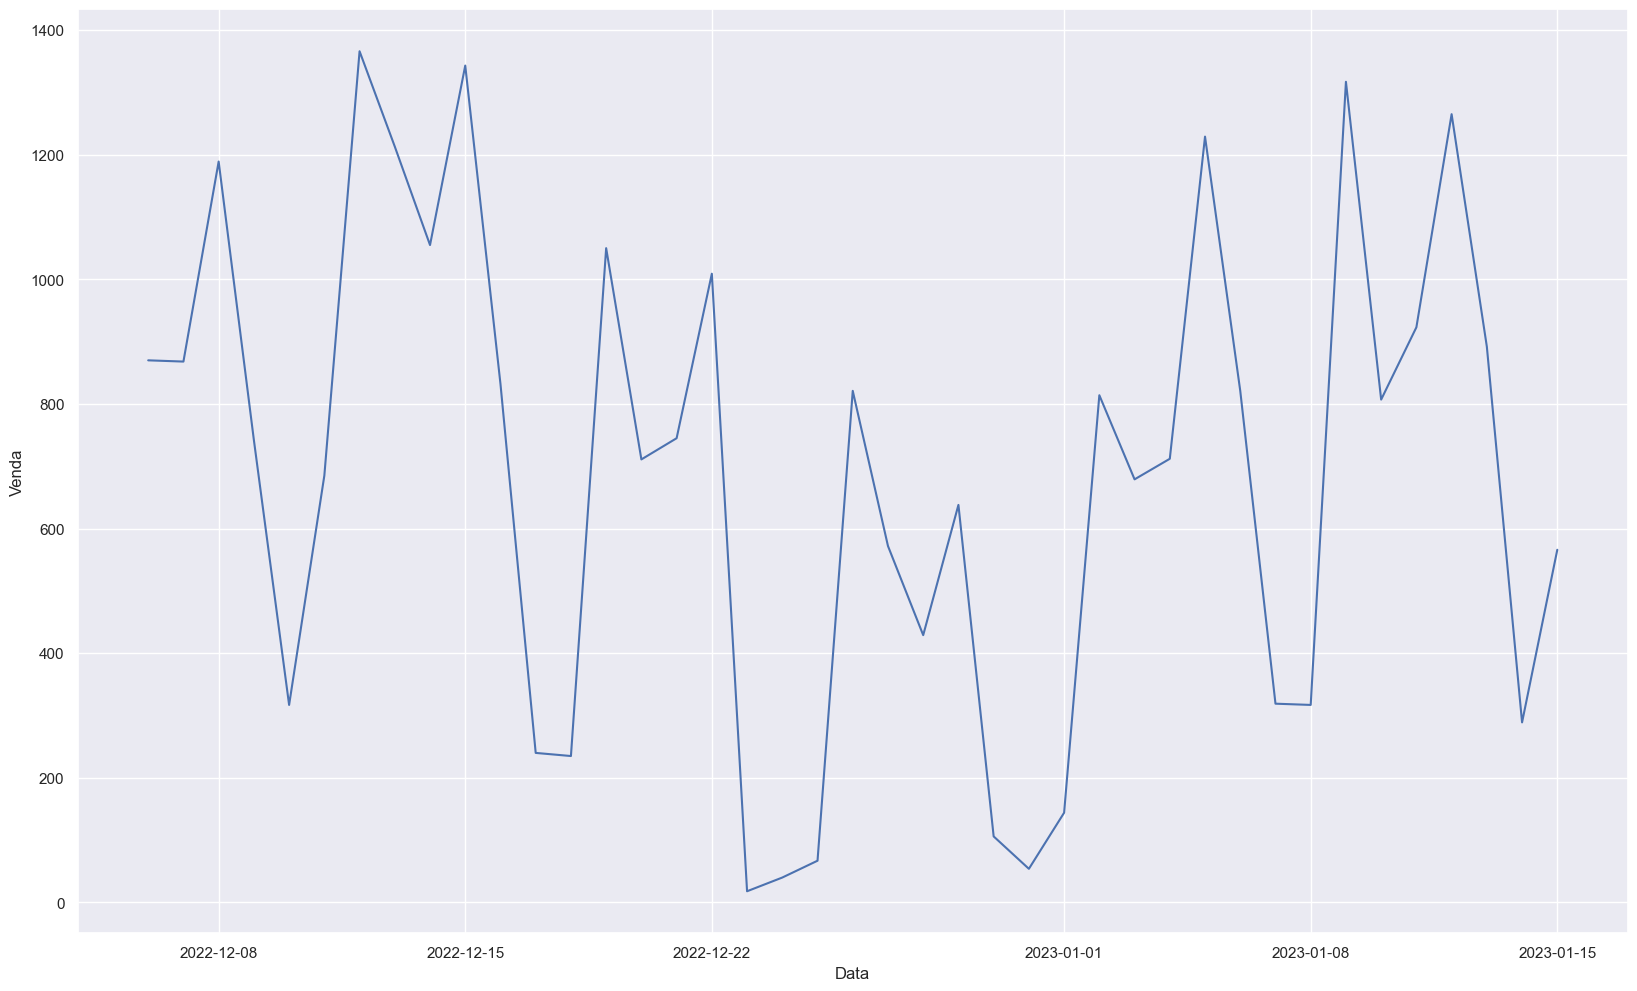

In [13]:
# Converter a coluna de data para o formato de data e definir como índice
df_train['Data'] = pd.to_datetime(df_train['Data'])
df_train = df_train.set_index('Data')
df_train = df_train.resample('D').sum()

# Plot dos dados
plt.plot(df_train)
plt.xlabel("Data")
plt.ylabel("Venda")
plt.show()

# Treinar o modelo SARIMA
model = ARIMA(df_train['Vendas'], order=(1, 0, 1), freq='D')
model = model.fit()

# Fazer previsões para os próximos 5 dias
forecast_train = model.forecast(steps=5)

In [14]:
forecast_train = pd.DataFrame(forecast_train).reset_index().rename(columns={"index": "Data", 'predicted_mean': 'Previsão_De_Vendas'})
forecast_train['Vendas'] = df_test['Vendas'].values
forecast_train

,Data,Previsão_De_Vendas,Vendas
0,2023-01-16,744.340715,1692
1,2023-01-17,687.653759,1097
2,2023-01-18,691.555607,1302
3,2023-01-19,691.287037,1405
4,2023-01-20,691.305523,945


In [15]:
model_arima_result = ml_error('Arima Regressior', Y_test, forecast_train['Previsão_De_Vendas'])
model_arima_result

,Model_Name,MAE,MAPE,RMSE
0,Arima Regressior,586.971472,0.435705,634.351938


## Performace final

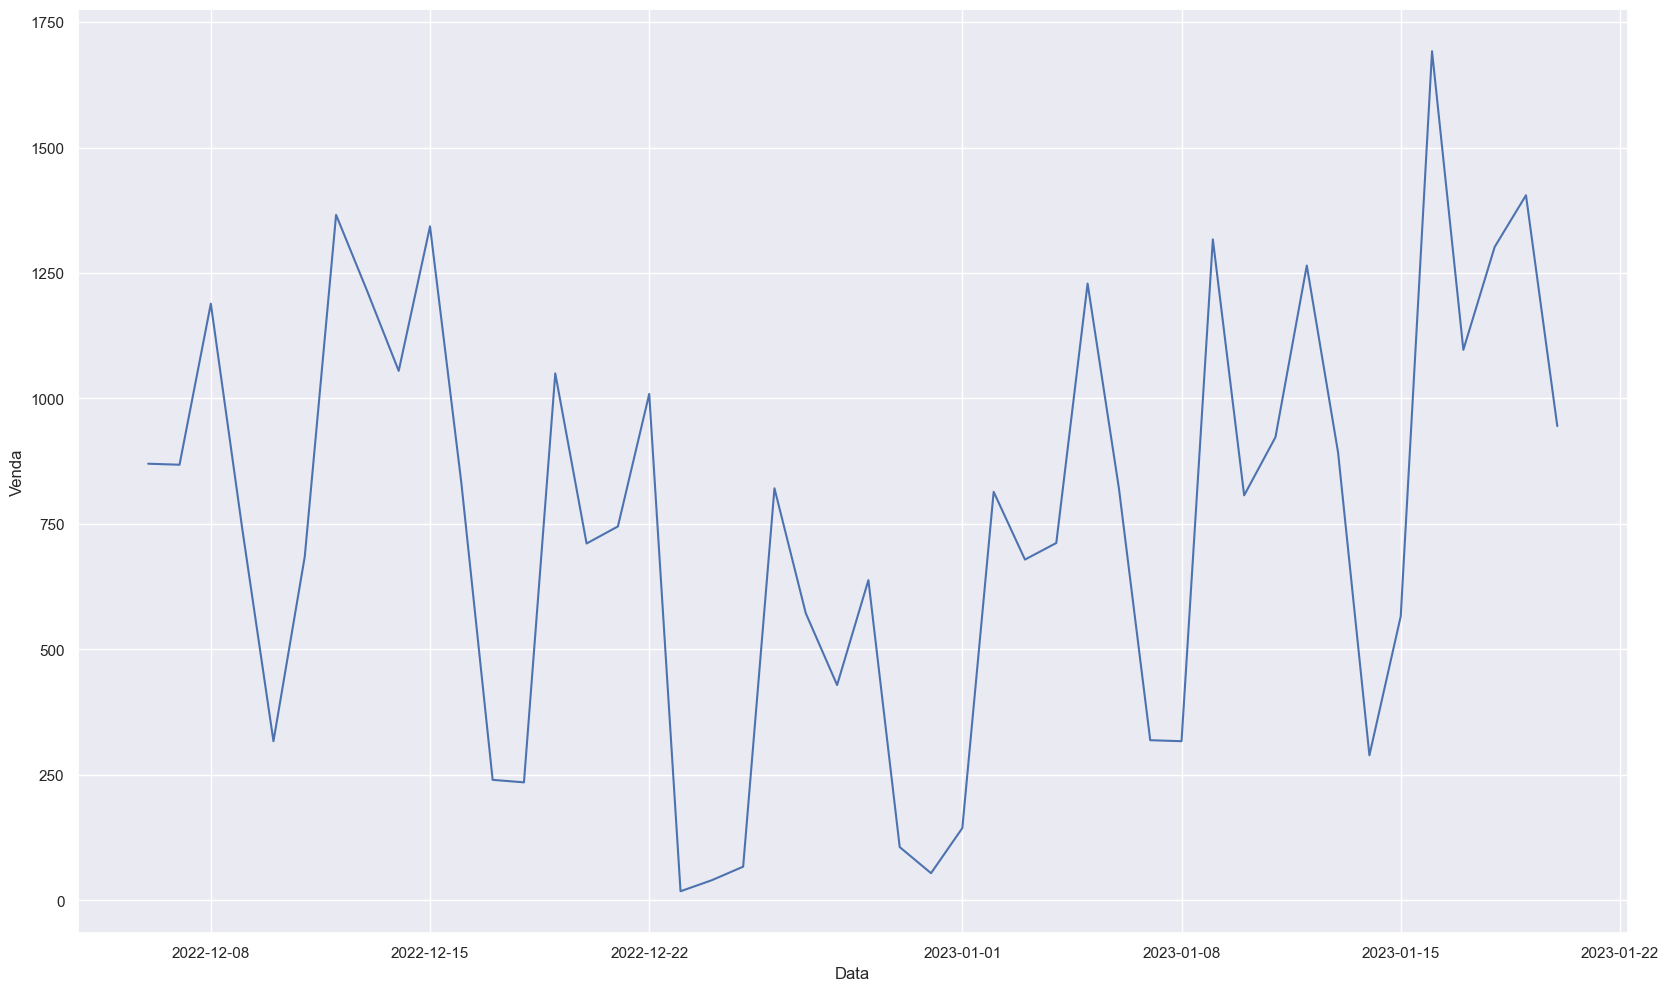

In [16]:
# Carregar dados de vendas
dff = df.copy()

# Converter a coluna de data para o formato de data e definir como índice
dff['Data'] = pd.to_datetime(dff['Data'])
dff = dff.set_index('Data')
dff = dff.resample('D').sum()

# Plot dos dados
plt.plot(dff)
plt.xlabel("Data")
plt.ylabel("Venda")
plt.show()

# Treinar o modelo SARIMA
model = ARIMA(dff['Vendas'], order=(1, 0, 1), freq='D')
model = model.fit()

# Fazer previsões para os próximos 5 dias
forecast_test = model.forecast(steps=5)

In [17]:
forecast_test = pd.DataFrame(forecast_test).reset_index().rename(columns={"index": "Data", 'predicted_mean': 'Previsão_De_Vendas'})
forecast_test['Vendas'] = df_test['Vendas'].values

In [18]:
df2 = forecast_test[['Data', 'Previsão_De_Vendas']].groupby('Data').sum().reset_index()

# MAE e MAPE
df3 = forecast_test.groupby('Data').apply(
    lambda x: mean_absolute_error(x['Vendas'], x['Previsão_De_Vendas'])).reset_index().rename( columns={0:'MAE'} )

df4 = forecast_test.groupby('Data').apply(
    lambda x: mean_absolute_percentage_error(x['Vendas'], x['Previsão_De_Vendas'])).reset_index().rename( columns={0:'MAPE'} )

# merge
df5 = pd.merge( df3, df4, how='inner', on='Data' )
df6 = pd.merge( df2, df5, how='inner', on='Data' )

# cenarios
df6['Pior_Cenario'] = df6['Previsão_De_Vendas'] - df6['MAE']
df6['Melhor_Cenario'] = df6['Previsão_De_Vendas'] + df6['MAE']

df6['Pior_Cenario'] = df6['Pior_Cenario'].mask(df6['Pior_Cenario'] < 0)

df6

,Data,Previsão_De_Vendas,MAE,MAPE,Pior_Cenario,Melhor_Cenario
0,2023-01-21,831.709999,860.290001,0.508446,NaN,1692.0
1,2023-01-22,727.664461,369.335539,0.336678,358.328922,1097.0
2,2023-01-23,767.249090,534.750910,0.410715,232.498179,1302.0
3,2023-01-24,752.188926,652.811074,0.464634,99.377853,1405.0
4,2023-01-25,757.918638,187.081362,0.197970,570.837277,945.0


Novamente, com uma base de dados pequena, é difícil ter uma precisão alta, mas fiz meu melhor :)